# Fe55 testing on electro-optical Camera test stand data

## Last run with w_2018_28, on July 19, 2018

First, importing...

In [1]:
import numpy as np
import lsst.daf.persistence as dafPersist
from lsst.ip.isr import AssembleCcdTask    # force an import of pcaPsfDeterminer.py (which selects ds9) (DM-13432)
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt

%matplotlib inline 
#%matplotlib notebook
#%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

In [2]:
afwDisplay.setDefaultBackend("matplotlib" if True else "ds9")


In [3]:
dataPath = "/datasets/comCam/repo/rtm5"

butler = dafPersist.Butler(dataPath)
print("Available runs: %s" % (" ".join(butler.queryMetadata('raw', ['run']))))  # available runs


Available runs: 4389 4417


In [4]:
print("Available visits: %s" % ("".join(str(butler.queryMetadata('raw', ['run','visit','testType','imageType','wavelength','exptime']))))) 

Available visits: [('4389', 269894410, 'DARK', 'BIAS', 550, 0.0), ('4389', 269894435, 'DARK', 'BIAS', 550, 0.0), ('4389', 269894460, 'DARK', 'BIAS', 550, 0.0), ('4389', 269894486, 'DARK', 'BIAS', 550, 0.0), ('4389', 269894511, 'DARK', 'BIAS', 550, 0.0), ('4389', 269895155, 'DARK', 'DARK', 550, 500.0), ('4389', 269895842, 'DARK', 'DARK', 550, 500.0), ('4389', 269896528, 'DARK', 'DARK', 550, 500.0), ('4389', 269897215, 'DARK', 'DARK', 550, 500.0), ('4389', 269892434, 'FE55', 'BIAS', 550, 0.0), ('4389', 269892463, 'FE55', 'BIAS', 550, 0.0), ('4389', 269892490, 'FE55', 'BIAS', 550, 0.0), ('4389', 269892518, 'FE55', 'BIAS', 550, 0.0), ('4389', 269892546, 'FE55', 'BIAS', 550, 0.0), ('4389', 269892754, 'FE55', 'FE55', 550, 120.0), ('4389', 269893006, 'FE55', 'FE55', 550, 120.0), ('4389', 269893257, 'FE55', 'FE55', 550, 120.0), ('4389', 269893506, 'FE55', 'FE55', 550, 120.0), ('4389', 269893758, 'FE55', 'FE55', 550, 120.0), ('4389', 269897766, 'FLAT', 'FLAT', 675, 0.327), ('4389', 269897868, '

Not sure which are Fe55 exposures...  From the sqlite3 table raw (and raw_visit), we can find:
run
basename
object
visit
dateObs
filter
field
ccd
lsstSerial
raft
testType
expTime
imageType

Apparently for Fe55, we have testType='FE55', there are 5x (BIAS and DARK) imageTypes

In [5]:
fe55_visits=butler.queryMetadata('raw', ['visit'],{'run':4389,'testType':'FE55','imageType':'FE55'})  # to get a list of fe55 visits in run 4389
bias_visits=butler.queryMetadata('raw', ['visit'],{'run':4389,'testType':'FE55','imageType':'BIAS'})  # to get a list of bias fe55 visits in run 4389
fe55_mjds=[(float(fe55_visit)*1e-5)+55197 for fe55_visit in fe55_visits]  # calulate the MJD time for each visit
bias_mjds=[(float(bias_visit)*1e-5)+55197 for bias_visit in bias_visits]  # calulate the MJD time for each visit
print(fe55_visits)
print(fe55_mjds)
print(bias_visits)
print(bias_mjds)

[269892754, 269893006, 269893257, 269893506, 269893758]
[57895.92754, 57895.93006, 57895.93257, 57895.93506, 57895.93758]
[269892434, 269892463, 269892490, 269892518, 269892546]
[57895.92434, 57895.92463, 57895.9249, 57895.92518, 57895.92546]


So all 5 bias exposures were taken prior to the fe55 exposures.

In [6]:
dataId=dict(visit=fe55_visits[0],ccd='S11')
fe55=butler.get('raw',dataId)

In [7]:
camera = butler.get("camera")

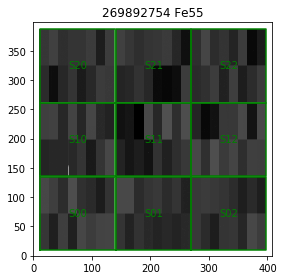

In [8]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = "raw"
imageType = "Fe55"
mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"],
                                                             callback=cameraGeomUtils.rawCallback),
                                 binSize=32, display=disp, title="%d %s" % (dataId["visit"], imageType))

we're going to use the eotest psf fitter

In [9]:
import lsst.eotest.sensor as sensorTest
import lsst.eotest.image_utils as imutils
import lsst.afw.image as afwImage


In [10]:
fitter = sensorTest.PsfGaussFit(nsig=2)
amp=0

for visit in fe55_visits:
    print("processing", visit)
    dataId=dict(visit=fe55_visits[0],ccd='S11')
    fe55=butler.get('raw',dataId).getMaskedImage()
    bbox=fe55.getBBox()
    fe55image = fe55.Factory(fe55, bbox, afwImage.LOCAL)

    print(dir(fe55image))
#    fe55image=fe55.image.array
    #
    # MaskedCCD is the principal data structure for the eotest package.
    # Masks can be specified by a non-empty tuple of mask_files.
    # 
    fitter.process_image(fe55image, amp)
#fitter.write_results('psf_results.fits')


processing 269892754
['Factory', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__ilshift__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__itruediv__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '_get', '_set', 'assign', 'census', 'clone', 'convertD', 'convertF', 'dtype', 'getArrays', 'getBBox', 'getDimensions', 'getHeight', 'getId', 'getImage', 'getMask', 'getNextMemId', 'getVariance', 'getWidth', 'getX0', 'getXY0', 'getY0', 'image', 'indexToPosition', 'markPersistent', 'mask', 'positionToIndex', 'readFits', 'repr', 'scaledDivides', 'scaledMinus', 'scaledMultiplies', 'scaledPlus', 'set', 'setDeleteCallbackId', 'setImage', 'setMask', 'setNewCallbackId', 'setVariance', 'setXY0', 'subset', 'swap', 'variance', 'writeFits']


AttributeError: 'lsst.afw.image.maskedImage.maskedImage.MaskedImage' object has no attribute 'bias_subtracted_image'